In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering

In [2]:
dataset = pd.read_excel('Online Retail.xlsx')

# EDA

In [3]:
dataset.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [4]:
# Alot of null value in Customer ID

In [5]:
dataset.loc[dataset['CustomerID'].isna()].shape

(135080, 8)

In [6]:
# Assumtion about NaN Value in customer_ID 
# Customer use guest account (1 time transaction) so it doesnt need an account to buy a product
# So we can apply the NaN value with their invoice instead

In [7]:
dataset['CustomerID'] = dataset.apply(
    lambda row: row['InvoiceNo'] if np.isnan(row['CustomerID']) else row['CustomerID'], axis=1
)

In [8]:
dataset.CustomerID = dataset.CustomerID.astype('str')

In [9]:
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [10]:
dataset.shape

(541909, 8)

In [11]:
dataset.isna().sum()

InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
dtype: int64

In [12]:
dataset.loc[dataset['Description'].isna()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,536414,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,536545,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,536546,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,536547,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,536549,United Kingdom


In [13]:
dataset = dataset.loc[~dataset['Description'].isna()]

# Explore Canceled Invoice

In [14]:
dataset['InvoiceNo'] = dataset['InvoiceNo'].astype('str')
dfCanceledInvoice = dataset.loc[dataset['InvoiceNo'].str.contains("C")]
dfStatedInvoice   = dataset.loc[~dataset['InvoiceNo'].str.contains("C")]
print('Canceled Order: ', dfCanceledInvoice['InvoiceNo'].nunique())
dfCanceledInvoice.head(2)

Canceled Order:  3836


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom


In [15]:
canceledInvoice = dfCanceledInvoice['InvoiceNo'].unique().tolist()
prepCanceled = [invoice.replace('C', '') for invoice in canceledInvoice]
dfStatedInvoice.loc[dfStatedInvoice['InvoiceNo'].isin(prepCanceled)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [16]:
# Theres a lot of canceled order (theres 'C' in the InvoiceNo)
# We want to look up if the canceled order also show up in the statedInvoice if we delete the 'C'
# Turns out theres no duplicated between canceled or stated invoice
# So we delete the canceled order

# Explore Quantity

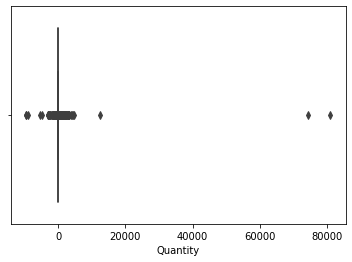

In [17]:
ax = sns.boxplot(x=dfStatedInvoice['Quantity'])

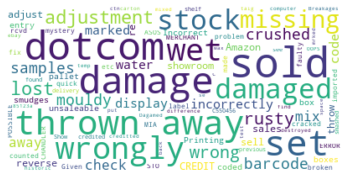

In [18]:
lDescription = dfStatedInvoice['Description'].loc[dfStatedInvoice['Quantity'] <= 0].unique().tolist()
text = ' '.join([str(elem) for elem in lDescription]) 
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Turns out when the quantity < 0 theres error in the order so we can delete it

In [19]:
dfStatedInvoice = dfStatedInvoice.loc[dfStatedInvoice['Quantity'] >= 0]
# dfStatedInvoice

In [20]:
dfStatedInvoice.loc[dfStatedInvoice['Quantity'] > 10000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.00,13256.0,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom


# Theres 2 item sold at 10000 quantity but turns out its not anomaly (maybe someone need a lot of paper craft for their project) so we still keep it

# Explore Price

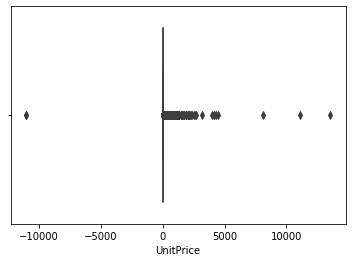

In [21]:
ax = sns.boxplot(x=dfStatedInvoice['UnitPrice'])

In [22]:
dfStatedInvoice.loc[dfStatedInvoice['UnitPrice'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,A563186,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,A563187,United Kingdom


In [23]:
dfStatedInvoice.loc[dfStatedInvoice['StockCode'] == 'B']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,A563185,United Kingdom
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,A563186,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,A563187,United Kingdom


In [24]:
dfStatedInvoice = dfStatedInvoice.loc[dfStatedInvoice['StockCode'] != 'B']
dfStatedInvoice.shape
# We found out that StockCode 'B' stands for Adjust bad debt so we can remove it

(530690, 8)

In [25]:
# dfStatedInvoice

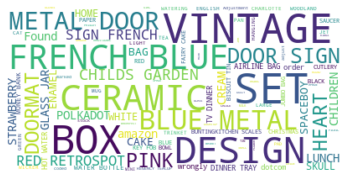

In [26]:
lDescription = dfStatedInvoice['Description'].loc[dfStatedInvoice['UnitPrice'] == 0].unique().tolist()
text = ' '.join([str(elem) for elem in lDescription]) 
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Looks like theres still an item sold for 0 price but we still don't know why the price sold at 0. So we decided keep it and make contact with client about this

In [27]:
dfStatedInvoice = dfStatedInvoice.loc[dfStatedInvoice['UnitPrice'] >= 0]
dfStatedInvoice.shape

(530690, 8)

In [28]:
dfStatedInvoice.loc[dfStatedInvoice['UnitPrice'] > 4000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
15017,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,537632,United Kingdom
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom
268028,560373,M,Manual,1,2011-07-18 12:30:00,4287.63,560373,United Kingdom
297723,562955,DOT,DOTCOM POSTAGE,1,2011-08-11 10:14:00,4505.17,562955,United Kingdom
422351,573077,M,Manual,1,2011-10-27 14:13:00,4161.06,12536.0,France
422376,573080,M,Manual,1,2011-10-27 14:20:00,4161.06,12536.0,France


In [29]:
checkThis = dfStatedInvoice['InvoiceNo'].loc[dfStatedInvoice['UnitPrice'] > 4000].tolist()
for invoice in checkThis:
    print(len(dfStatedInvoice.loc[dfStatedInvoice['InvoiceNo'] == invoice]))

1
1
1
353
1
1


In [30]:
# Only InvoiceNo 562955 that got a lot of transaction and the other only got 1 so we will delete the outlier price
# 1 invoice but price was too expensive
checkThis.remove('562955')
dfStatedInvoice = dfStatedInvoice.loc[~dfStatedInvoice['InvoiceNo'].isin(checkThis)]

# Theres also StockCode called 'POST' turns out its a delivery price so we will keep it

In [31]:
dfStatedInvoice.loc[dfStatedInvoice['StockCode'] == 'POST'].head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.0,12583.0,France
386,536403,POST,POSTAGE,1,2010-12-01 11:27:00,15.0,12791.0,Netherlands
1123,536527,POST,POSTAGE,1,2010-12-01 13:04:00,18.0,12662.0,Germany


# Theres also StockCode called 'M' we can assume it is offline store transaction so we will keep the record

In [32]:
dfStatedInvoice.loc[dfStatedInvoice['StockCode'] == 'M'].head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
2239,536569,M,Manual,1,2010-12-01 15:35:00,1.25,16274.0,United Kingdom
2250,536569,M,Manual,1,2010-12-01 15:35:00,18.95,16274.0,United Kingdom
5684,536865,M,Manual,1,2010-12-03 11:28:00,2.55,536865,United Kingdom


In [33]:
dfStatedInvoice.loc[dfStatedInvoice['InvoiceNo'] == '536865'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
5546,536865,10002,INFLATABLE POLITICAL GLOBE,5,2010-12-03 11:28:00,1.66,536865,United Kingdom
5547,536865,15056bl,EDWARDIAN PARASOL BLACK,2,2010-12-03 11:28:00,12.72,536865,United Kingdom
5548,536865,18098c,PORCELAIN BUTTERFLY OIL BURNER,7,2010-12-03 11:28:00,5.06,536865,United Kingdom
5549,536865,20615,BLUE POLKADOT PASSPORT COVER,1,2010-12-03 11:28:00,4.21,536865,United Kingdom
5550,536865,20655,QUEEN OF SKIES LUGGAGE TAG,1,2010-12-03 11:28:00,2.51,536865,United Kingdom


In [34]:
dfStatedInvoice.groupby(by=['Country']).nunique().sort_values('InvoiceNo', ascending=False).head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Country,,,,,,,,
United Kingdom,18188,3918,4057,377,16938,1243,5461,1
Germany,457,1665,1697,47,452,106,94,1
France,390,1542,1564,55,391,95,90,1


# Feature Engineering

RFM is a method used for analyzing customer value. It is commonly used in database marketing and direct marketing and has received particular attention in retail and professional services industries.[1]

RFM stands for the three dimensions:

Recency – How recently did the customer purchase?
Frequency – How often do they purchase?
Monetary Value – How much do they spend?

# Customer Segmentation is affected by Country so we choose the most transaction made by country which is UK

In [35]:
dfStatedInvoice = dfStatedInvoice.loc[dfStatedInvoice['Country'] == 'United Kingdom']
dfStatedInvoice.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom


In [36]:
# dfStatedInvoice['InvoiceDate'] = dfStatedInvoice['InvoiceDate'].dt.date
dfStatedInvoice.shape

(485688, 8)

In [37]:
# latestTransaction

In [38]:
#last date available in our dataset
latestTransaction = dfStatedInvoice['InvoiceDate'].max()
df1Year = dfStatedInvoice.loc[dfStatedInvoice['InvoiceDate'] >= latestTransaction - datetime.timedelta(days=365)]
df1Year.shape

(466895, 8)

In [39]:
#group by customers and check last date of purchase
dfCustomer = df1Year.groupby(by='CustomerID', as_index=False)['InvoiceDate'].max()
dfCustomer.columns = ['CustomerID','LastPurchaseDate']
dfCustomer.head()

,CustomerID,LastPurchaseDate
0,12346.0,2011-01-18 10:01:00
1,12747.0,2011-12-07 14:34:00
2,12748.0,2011-12-09 12:20:00
3,12749.0,2011-12-06 09:56:00
4,12820.0,2011-12-06 15:12:00


In [40]:
dfCustomer.shape

(5350, 2)

In [41]:
#calculate recency
dfCustomer['Recency'] = dfCustomer['LastPurchaseDate'].apply(lambda x: (latestTransaction - x).days / 30)
dfCustomer.head(1)

,CustomerID,LastPurchaseDate,Recency
0,12346.0,2011-01-18 10:01:00,10.833333


In [42]:
# calculate Frequency
dfCustomer['TotalPurchase'] = df1Year.groupby(by='CustomerID', as_index=False).nunique()[['InvoiceNo']]
dfCustomer.head(1)

,CustomerID,LastPurchaseDate,Recency,TotalPurchase
0,12346.0,2011-01-18 10:01:00,10.833333,1


In [43]:
# Monetary
df1Year['TotalPrice'] = df1Year['Quantity'] * df1Year['UnitPrice']
dfCustomer['TotalSpending'] = df1Year.groupby(by='CustomerID', as_index=False).sum()[['TotalPrice']]
dfCustomer.head(1)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,CustomerID,LastPurchaseDate,Recency,TotalPurchase,TotalSpending
0,12346.0,2011-01-18 10:01:00,10.833333,1,77183.6


In [44]:
dfCustomer = dfCustomer.drop(['LastPurchaseDate'], axis = 1)
dfCustomer.head(1)

,CustomerID,Recency,TotalPurchase,TotalSpending
0,12346.0,10.833333,1,77183.6


(3.0, 0.0)

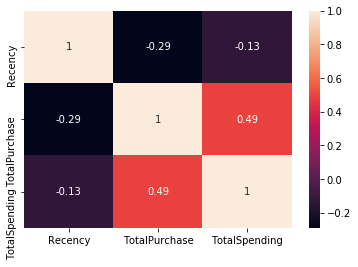

In [45]:
df_corr = dfCustomer.corr()
ax = sns.heatmap(df_corr, annot=True) #notation: "annot" not "annote"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

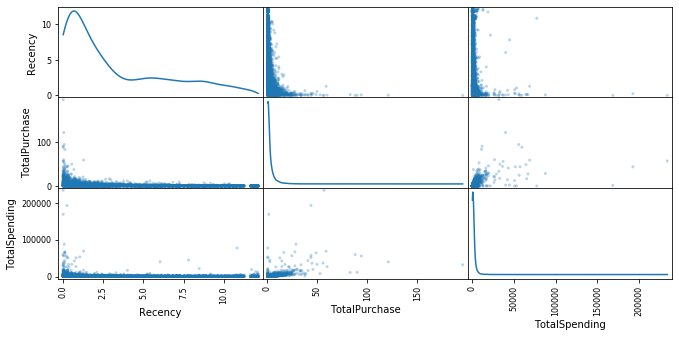

In [46]:
pd.plotting.scatter_matrix(dfCustomer, alpha = 0.3, figsize = (11,5), diagonal = 'kde')
plt.show()

In [47]:
# import copy
transformedDF = dfCustomer.iloc[:]
# Add 0.05 to handling nan value
transformedDF['Recency'] = np.log(dfCustomer['Recency']+0.05)
transformedDF['TotalPurchase'] = np.log(dfCustomer['TotalPurchase']+0.05)
transformedDF['TotalSpending'] = np.log(dfCustomer['TotalSpending']+0.05)

(3.0, 0.0)

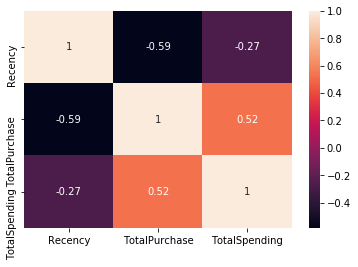

In [48]:
df_corr = transformedDF.corr()
ax = sns.heatmap(df_corr, annot=True) #notation: "annot" not "annote"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

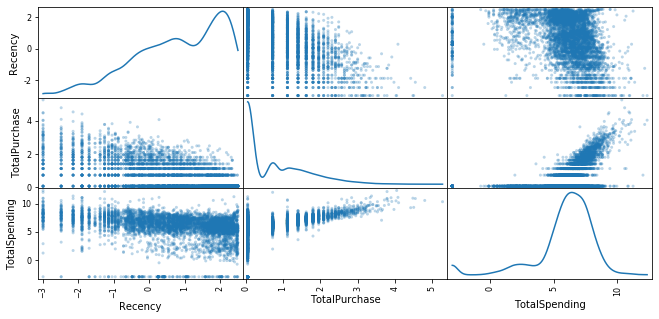

In [49]:
pd.plotting.scatter_matrix(transformedDF.iloc[:,1:4], alpha = 0.3, figsize = (11,5), diagonal = 'kde')
plt.show()

In [50]:
X = transformedDF.iloc[:]
# X = dfCustomer.iloc[:]

In [51]:
for i in range (2, 6):
    hc = AgglomerativeClustering(n_clusters = i, affinity = 'euclidean', linkage = 'ward')
    y_hc = hc.fit_predict(X)
    dfCustomer['Clusters'] = y_hc
    score  = davies_bouldin_score(dfCustomer, dfCustomer['Clusters'])
    print('With' , i, 'Clusters the score is:' , score)

With 2 Clusters the score is: 0.022206470393692425
With 3 Clusters the score is: 0.3612310141973127
With 4 Clusters the score is: 0.3602568645839488
With 5 Clusters the score is: 0.3891383533613868


In [52]:
# import scipy.cluster.hierarchy as sch
# dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
# plt.title('Dendrogram')
# plt.xlabel('Customers')
# plt.ylabel('Euclidean distances')
# plt.show()

In [53]:
hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X)
dfCustomer['Clusters'] = y_hc
dfCustomer

,CustomerID,Recency,TotalPurchase,TotalSpending,Clusters
0,12346.0,2.387233,1,11.253943,1
1,12747.0,-2.484907,10,8.252576,1
2,12748.0,-2.995732,195,10.365734,1
3,12749.0,-1.897120,5,8.316528,1
4,12820.0,-2.148434,4,6.848419,1
...,...,...,...,...,...
5345,581435,-2.995732,1,1.223775,0
5346,581439,-2.995732,1,8.800512,0
5347,581492,-2.995732,1,8.947582,0
5348,581497,-2.995732,1,8.076282,0


In [54]:
print('Customer in cluster 1: ', len(dfCustomer.loc[dfCustomer['Clusters'] == 0]))
print('Customer in cluster 2: ', len(dfCustomer.loc[dfCustomer['Clusters'] == 1]))

Customer in cluster 1:  1490
Customer in cluster 2:  3860


In [55]:
print('Info about cluster 1')
dfCustomer.loc[dfCustomer['Clusters'] == 0].describe()

Info about cluster 1


,Recency,TotalPurchase,TotalSpending,Clusters
count,1490.000000,1490.0,1490.000000,1490.0
mean,1.422250,1.0,4.320763,0.0
std,1.070212,0.0,3.517850,0.0
min,-2.995732,1.0,-2.995732,0.0
25%,0.961901,1.0,2.079442,0.0
50%,1.783391,1.0,5.539807,0.0
75%,2.187922,1.0,7.306109,0.0
max,2.500069,1.0,10.876933,0.0


In [56]:
print('Info about cluster 2')
dfCustomer.loc[dfCustomer['Clusters'] == 1].describe()

Info about cluster 2


,Recency,TotalPurchase,TotalSpending,Clusters
count,3860.000000,3860.000000,3860.000000,3860.0
mean,0.363151,4.141710,6.529806,1.0
std,1.366409,6.921233,1.248851,0.0
min,-2.995732,1.000000,-2.995732,1.0
25%,-0.538997,1.000000,5.691102,1.0
50%,0.520776,2.000000,6.465608,1.0
75%,1.500367,5.000000,7.348169,1.0
max,2.500069,195.000000,12.361952,1.0
